In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as wnl
from nltk.stem import PorterStemmer
import re
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize TF-IDF Vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Limit to top 1000 features for efficiency
    stop_words='english',  # Remove English stopwords
    lowercase=True,
    token_pattern=r'(?u)\b\w{3,}\b',  # Only alphabetic tokens with 3+ characters
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.90  # Ignore terms that appear in more than n% of documents
)

stemmer = PorterStemmer()
lemmatizer = wnl()

# Initialize Count Vectorizer for bag-of-words
# count_vectorizer = CountVectorizer(
#     max_features=1000,
#     stop_words='english',
#     lowercase=True,
#     token_pattern=r'(?u)\b\w{3,}\b',
#     min_df=2,
#     max_df=0.90
# )

def clean_utf_characters(text):
    """
    Clean UTF characters from text, including zero-width characters, 
    emoji, and other non-printable Unicode characters.
    
    Parameters:
    text (str): Input text containing UTF characters
    
    Returns:
    str: Cleaned text with UTF characters removed or normalized
    """
    if not isinstance(text, str):
        return text
    
    # Remove zero-width characters (like \u200c, \u200d, etc.)
    zero_width_chars = [
        '\u200b',  # zero-width space
        '\u200c',  # zero-width non-joiner
        '\u200d',  # zero-width joiner
        '\u2060',  # word joiner
        '\ufeff',  # byte order mark
        '\u200e',  # left-to-right mark
        '\u200f',  # right-to-left mark
        '\u202a',  # left-to-right embedding
        '\u202b',  # right-to-left embedding
        '\u202c',  # pop directional formatting
        '\u202d',  # left-to-right override
        '\u202e',  # right-to-left override
    ]
    
    for char in zero_width_chars:
        text = text.replace(char, '')
    
    # Remove other invisible/control characters
    text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\x9f]', '', text)
    
    # Remove or replace emoji and other Unicode symbols
    # Keep basic punctuation but remove decorative symbols
    text = re.sub(r'[^\w\s\.\,\!\?\;\:\-\(\)\[\]\{\}\'\"\/\\\@\#\$\%\^\&\*\=\+\|`~]', ' ', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

def clean_dataframe_column(df, column_name):
    """
    Apply UTF cleaning to a specific column in a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    column_name (str): Name of the column to clean
    
    Returns:
    pandas.DataFrame: DataFrame with cleaned column
    """
    if column_name not in df.columns:
        print(f"Warning: Column '{column_name}' not found in DataFrame")
        return df
    
    # Create a copy to avoid modifying original
    df_cleaned = df.copy()
    
    # Apply cleaning function to the specified column
    df_cleaned[column_name] = df_cleaned[column_name].apply(clean_utf_characters)
    
    return df_cleaned


# test_text = "Moran Minute: He is Risen! ✝️ As We Celebrate Easter, Here\\'s What I\\'m Working on for East Texas \u200c \u200c \u200c \u200c"
# print("Original text:")
# print(repr(test_text))
# print("\nCleaned text:")
# cleaned = clean_utf_characters(test_text)
# print(repr(cleaned))
# print(f"\nCleaned text (readable): {cleaned}")

def tokenize_words(text, remove_stop_words=True):
    """
    Optimized tokenization with better preprocessing order.
    """
    if isinstance(text, list):
        text = ' '.join(text)

    # Basic text normalization BEFORE tokenization
    text = re.sub(r'\s+', ' ', text.strip())  # Normalize whitespace
    
    # Tokenize first (this is correct!)
    tokenizer = TweetTokenizer()
    words = tokenizer.tokenize(text)
    
    # Now clean the tokens
    words = [re.sub(r"[^\w]", '', word) for word in words]  # Remove punctuation
    words = [word.lower() for word in words]  # Lowercase
    words = [word for word in words if word]  # Remove empty strings
    
    # Filter short words
    words = [word for word in words if len(word) > 1 or word in ['i']]
    words = [word for word in words if word != 'ni']
    
    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]

    # compare to stem - uh no
    # words = [stemmer.stem(word) for word in words]

    new_custom_stopwords = ['ha', 'wa']
    
    # Remove stopwords if the option is selected
    if remove_stop_words:
        try:
            stop_words = set(stopwords.words('english'))
            stop_words.update(new_custom_stopwords)
            words = [word for word in words if word.lower() not in stop_words]
        except LookupError:
            print("Warning: Could not load NLTK stopwords. Proceeding without stopword removal.")
            # Fallback to basic stopwords
            basic_stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should'}
            words = [word for word in words if word.lower() not in basic_stopwords]

    return words

def get_bag_of_words(words):
    """
    Generates word frequency data including counts and probabilities.
    
    Parameters:
    - words (list): List of words to analyze for frequency.
    
    Returns:
    - DataFrame: DataFrame with word counts.
    """
    bow = pd.Series(words).value_counts().reset_index()
    bow.columns = ['word', 'counts']        
    # bow['total_unique'] = len(bow)
    bow = bow.sort_values(by='counts', ascending=False).reset_index(drop=True)
    # print total number of words
    print(f"Total number of words in bag of words: {len(bow)}")

    return bow

# def get_bag_of_words(texts):
#     """
#     Alternative implementation using CountVectorizer
    
#     Parameters:
#     - texts (list): List of raw text documents
    
#     Returns:
#     - DataFrame: DataFrame with word counts
#     """
    
#     count_matrix = count_vectorizer.fit_transform(texts)
#     feature_names = count_vectorizer.get_feature_names_out()
    
#     total_counts = np.sum(count_matrix.toarray(), axis=0)
    
#     bow_df = pd.DataFrame({
#         'word': feature_names,
#         'counts': total_counts
#     }).sort_values('counts', ascending=False).reset_index(drop=True)
    
#     print(f"Total number of words in bag of words: {len(bow_df)}")
    
#     return bow_df


# 1.1: Corpus selection and metadata

For this project, I chose to work with a politically themed dataset spanning 2010-2025. The key feature of the dataset is the "Body" column, which is comprised of emails written by congressional members to their constituents. In addition to the email content, each row contains information about the congressional member, including district, state, chamber, and first and last name.
### Research Question
My question in analyzing this dataset was: How does the language of othering and fearmongering congressional members use differ across party lines? 
### Initial Findings
Using a simple word frequency counting approach, patterns and potential narratives begin to surface. An interesting pattern is that both sides frequently reference the opposing party's leadership—Republicans frequently mention Biden, while Democrats frequently mention Trump. Both parties demonstrate high focus on elections, suggesting the political salience of electoral processes in congressional communications.
Most notably, both parties place considerable emphasis on "security." However, based on other frequently appearing words, one could speculate that "security" carries very different meanings depending on which side of the aisle representatives occupy. On the Republican side, "border" appears as a term of seemingly high significance, while on the Democratic side, "health" and "rights" feature prominently. This suggests that Republicans may frame security primarily through immigration and border control, while Democrats may conceptualize security through healthcare access and civil rights protection.
### Data Limitations and Considerations
It should be noted that this initial examination of the data is somewhat cursory and has several limitations that warrant further investigation:
**Partisan Imbalance:** The dataset contains more than a 2:1 ratio of Republican records to Democratic records.
**Distribution over time:** While the records span 15 years (2010-2025), they are heavily skewed toward 2018-2024, with earlier years represented by dozens of records and later years by hundreds. This temporal imbalance may reflect both increased digital communication practices and potential collection biases.
**Chamber Representation:** The dataset presents challenges for chamber-based analysis, containing 1,506 House records compared to only 171 Senate records. This disparity limits the ability to draw meaningful comparisons between the two chambers.
### Future Research Directions
Other potentially interesting analytical dimensions include filtering by gender and state, which could reveal additional patterns in political communication strategies. A more sophisticated analysis might address the data imbalances through sampling techniques or weighted approaches, and could employ more advanced NLP methods beyond simple word counting to capture semantic differences in how parties discuss similar topics.

# Task 1.2: Text Cleaning
- Load your text(s) into Python.
- Do basic prepossessing on the text: convert text to lowercase, stem or lemmatize text, remove stop words, and drop 
punctuation
- Explain why doing these preprocessing steps would not or would not be ideal for your research question (in writeup)

In [477]:
# create and merge dataframes
df_f = pd.read_csv('./Data/dcinbox_export__election_f.csv')
df_i = pd.read_csv('./Data/dcinbox_export__election_i.csv')
df_s = pd.read_csv('./Data/dcinbox_export__election_s.csv')
df_frau = pd.read_csv('./Data/dcinbox_export__voter_frau.csv')
df = pd.concat([df_f, df_i, df_s, df_frau])
df = df.drop_duplicates(subset=['ID', 'Unix Timestamp', 'State', 'Chamber', 'Party', 'Body'], keep='first')
df = clean_dataframe_column(df, 'Body')
df.head(10)
# print(df.shape)

# print(df.State.value_counts())
# print(df.State.unique())
# print(df.Chamber.value_counts())
# print(df.Party.value_counts())

# print(df.info())


,Subject,Body,Unix Timestamp,BioGuide ID,Congress,First Name,Last Name,Date of Birth,Gender,State,District,Party,Chamber,Nickname,ID
0,Moran Minute: He is Risen! ✝️,Moran Minute: He is Risen! As We Celebrate Eas...,1745073029000,M001224,119,Nathaniel,Moran,1974-07-22,M,TX,1.0,Republican,House,NaN,252343
1,"Week of March 31, 2025",News from Congressman Abe Hamadeh [image: Imag...,1743737940000,H001098,119,Abraham,Hamadeh,1991-05-15,M,AZ,8.0,Republican,House,NaN,251587
2,It's a New Day at the Southern Border,It's a New Day at the Southern Border Securing...,1743345352000,B001291,119,Brian,Babin,1948-03-23,M,TX,36.0,Republican,House,NaN,251278
3,Rep. Randy Weber e-Newsletter,Rep. Randy Weber e-Newsletter Introducing Cens...,1743181448000,W000814,119,Randy,Weber,1953-07-02,M,TX,14.0,Republican,House,NaN,251173
4,Mario's Message,"Email from Rep. Diaz-Balart February 04, 2025 ...",1738661804000,D000600,119,Mario,Diaz-Balart,1961-09-25,M,FL,26.0,Republican,House,NaN,248655
5,Reminder: Randy's Roundup: Do you think that e...,Email from Rep Feenstra In this week's roundup...,1732541491000,F000446,118,Randy,Feenstra,1969-01-14,M,IA,4.0,Republican,House,NaN,245957
6,This Week With Claudia #NY24,Email from Rep. Tenney Congresswoman Tenney's ...,1732366837000,T000478,118,Claudia,Tenney,1961-02-04,F,NY,24.0,Republican,House,NaN,245910
7,Randy's Roundup: Do you think that every ballo...,Email from Rep Feenstra In this week's roundup...,1732294227000,F000446,118,Randy,Feenstra,1969-01-14,M,IA,4.0,Republican,House,NaN,245842
8,Antidote Election,It's not too hard for Ravens fans to picture o...,1730541843000,C000141,118,Benjamin,Cardin,1943-10-05,M,MD,NaN,Democrat,Senate,NaN,245128
9,July 2024 Month in Review _ Resumen del Mes de...,La versión en español está a continuación Hell...,1724168425000,G000551,118,Raúl,Grijalva,1948-02-19,M,AZ,7.0,Democrat,House,NaN,242026


# Task 1.3: Tokenization
- Implement a tokenizer of your choosing
- Document why you chose the tokenization method (in writeup)

In [478]:
words = df['Body'].values.tolist()
tokenized_words = tokenize_words(words)

# Task 2.1: Bag-of-Words Representation
- Construct a Bag-of-Words (BoW) model from your corpus using scikit-learn
- Identify the top 20 most frequent words
- Compare whether they match the themes you anticipated from your reading. (in writeup)

In [479]:
bow = get_bag_of_words(tokenized_words)
top_20_bow = bow.head(20)
top_20_bow.index += 1
print(top_20_bow)

Total number of words in bag of words: 35606
          word  counts
1     election    8044
2       office    7407
3         vote    7250
4        state    7243
5          act    6803
6        house    6710
7     american    6286
8         week    5963
9         bill    5626
10        work    4956
11  washington    4817
12    congress    4682
13     federal    4664
14       click    4607
15   president    4424
16        year    4340
17         new    3983
18       would    3794
19     support    3776
20        make    3746


In [485]:
r_df = df[df['Party'] == 'Republican']
d_df = df[df['Party'] == 'Democrat']

r_words = r_df['Body'].values.tolist()
d_words = d_df['Body'].values.tolist()

r_words = tokenize_words(r_words)
d_words = tokenize_words(d_words)

r_bow = get_bag_of_words(r_words)
d_bow = get_bag_of_words(d_words)

print('Republican Bag of Words:')
print(r_bow.head(20))
print('_'*100)
print('Democrat Bag of Words:')
print(d_bow.head(20))


Total number of words in bag of words: 28290
Total number of words in bag of words: 18926
Republican Bag of Words:
          word  counts
0     election    5866
1       office    5397
2        state    5376
3     american    4852
4        house    4850
5         vote    4809
6          act    4764
7         week    4576
8         bill    4071
9   washington    3503
10    congress    3449
11     federal    3433
12       click    3428
13        work    3380
14   president    3110
15        year    3064
16     support    2793
17         new    2767
18       would    2760
19    district    2616
____________________________________________________________________________________________________
Democrat Bag of Words:
          word  counts
0         vote    2441
1     election    2178
2          act    2039
3       office    2010
4        state    1867
5        house    1860
6         work    1576
7         bill    1555
8     american    1434
9         week    1387
10  washington    1314
11

# Task 2.2: TF–IDF Representation
- Construct a TF-IDF representation of your corpus.
- Plot the top TF-IDF–scored words for your text using a bar chart.
- Compare TF-IDF keywords with BoW keywords: what’s different? Which representation is more meaningful for thematic analysis? (in writeup)

In [486]:
print(f"Calculating TF-IDF for entire dataset ({len(df)} documents)...")
full_tfidf_matrix = tfidf_vectorizer.fit_transform(df['Body'])
full_feature_names = tfidf_vectorizer.get_feature_names_out()

full_mean_scores = np.mean(full_tfidf_matrix.toarray(), axis=0)
full_tfidf_df = pd.DataFrame({
    'word': full_feature_names,
    'tfidf_score': full_mean_scores
}).sort_values('tfidf_score', ascending=False)

print("Top 15 TF-IDF words across entire dataset:")
print(full_tfidf_df.head(15).to_string(index=False))

Calculating TF-IDF for entire dataset (1677 documents)...
Top 15 TF-IDF words across entire dataset:
      word  tfidf_score
    office     0.065587
       act     0.056548
     house     0.055630
      week     0.052709
     click     0.047648
washington     0.046748
     biden     0.046577
 president     0.044338
  congress     0.042584
   federal     0.041885
 elections     0.040618
     phone     0.040262
       new     0.039873
     state     0.039144
      vote     0.039143


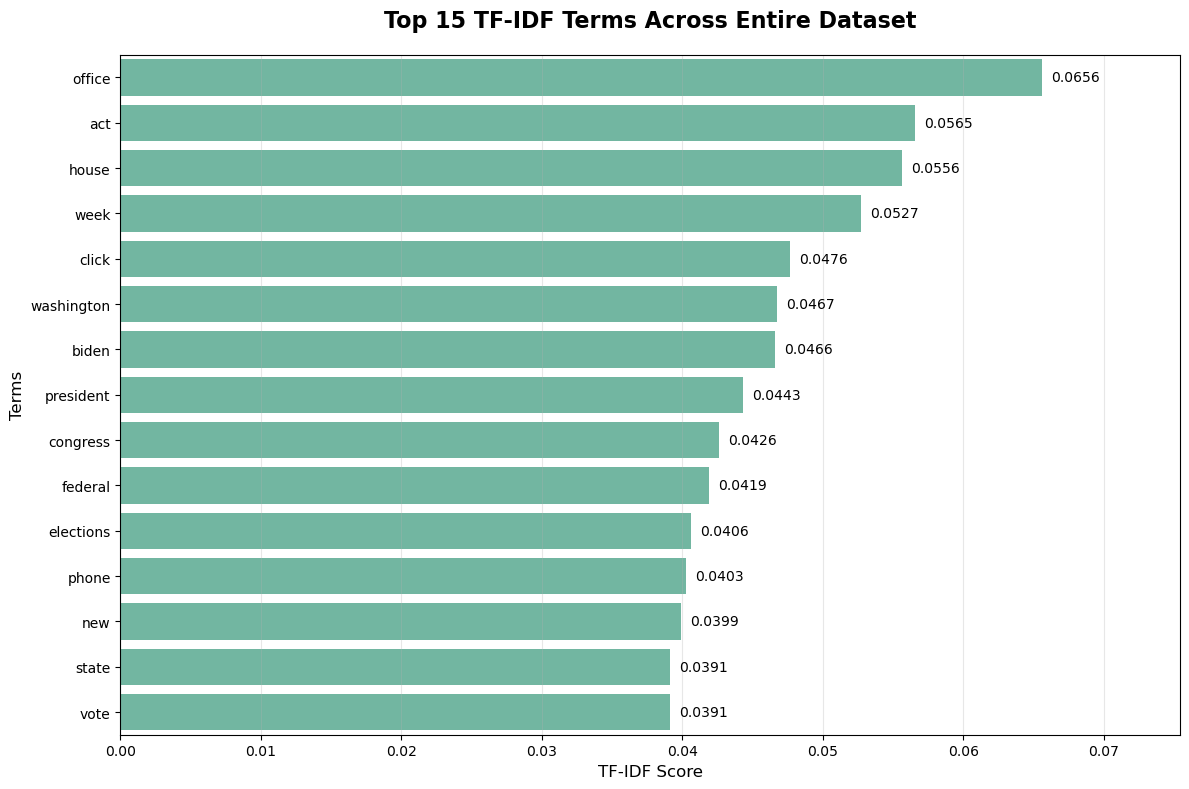

In [487]:
plt.style.use('default')
sns.set_palette("Set2") # neutral palette I like

# Create the seaborn bar plot for top 15 TF-IDF terms
plt.figure(figsize=(12, 8))
top_15_tfidf = full_tfidf_df.head(15)

# Create horizontal bar plot for better readability
ax = sns.barplot(data=top_15_tfidf, y='word', x='tfidf_score', orient='h')

# Customize the plot
plt.title('Top 15 TF-IDF Terms Across Entire Dataset', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('TF-IDF Score', fontsize=12)
plt.ylabel('Terms', fontsize=12)

# Add value labels on bars with better positioning
max_score = top_15_tfidf['tfidf_score'].max()
for i, v in enumerate(top_15_tfidf['tfidf_score']):
    # Position text slightly to the right of the bar end, with padding
    ax.text(v + (max_score * 0.01), i, f'{v:.4f}', va='center', fontsize=10, ha='left')

# Set x-axis limits to accommodate the text labels
plt.xlim(0, max_score * 1.15)

# Improve layout
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

In [488]:
print(f"Total documents: {len(df)}")
print(f"Republican documents: {len(r_df)}")
print(f"Democrat documents: {len(d_df)}")


# Fit and transform Republican documents
print("\nCalculating TF-IDF for Republican documents...")
r_tfidf_matrix = tfidf_vectorizer.fit_transform(r_df['Body'])
r_feature_names = tfidf_vectorizer.get_feature_names_out()

# Get mean TF-IDF scores for Republican documents
r_mean_scores = np.mean(r_tfidf_matrix.toarray(), axis=0)
r_tfidf_df = pd.DataFrame({
    'word': r_feature_names,
    'tfidf_score': r_mean_scores
}).sort_values('tfidf_score', ascending=False)

print("Top 15 Republican TF-IDF words:")
print(r_tfidf_df.head(15))

# Fit and transform Democrat documents
print("\nCalculating TF-IDF for Democrat documents...")
d_tfidf_matrix = tfidf_vectorizer.fit_transform(d_df['Body'])
d_feature_names = tfidf_vectorizer.get_feature_names_out()

# Get mean TF-IDF scores for Democrat documents
d_mean_scores = np.mean(d_tfidf_matrix.toarray(), axis=0)
d_tfidf_df = pd.DataFrame({
    'word': d_feature_names,
    'tfidf_score': d_mean_scores
}).sort_values('tfidf_score', ascending=False)

print("Top 15 Democrat TF-IDF words:")
print(d_tfidf_df.head(15))


Total documents: 1677
Republican documents: 1148
Democrat documents: 529

Calculating TF-IDF for Republican documents...
Top 15 Republican TF-IDF words:
          word  tfidf_score
617     office     0.067346
436      house     0.057942
108      biden     0.056948
975       week     0.056069
24         act     0.055975
170      click     0.050537
114     border     0.046459
335    federal     0.044171
201   congress     0.044025
296  elections     0.043442
675  president     0.042897
55    american     0.042437
657      phone     0.040893
855      state     0.039639
275   district     0.039500

Calculating TF-IDF for Democrat documents...
Top 15 Democrat TF-IDF words:
           word  tfidf_score
623      office     0.062249
36          act     0.056703
925       trump     0.053377
437       house     0.050242
691   president     0.047645
969  washington     0.045012
976        week     0.043743
957        vote     0.043246
962      voting     0.042735
614         new     0.042536
174 

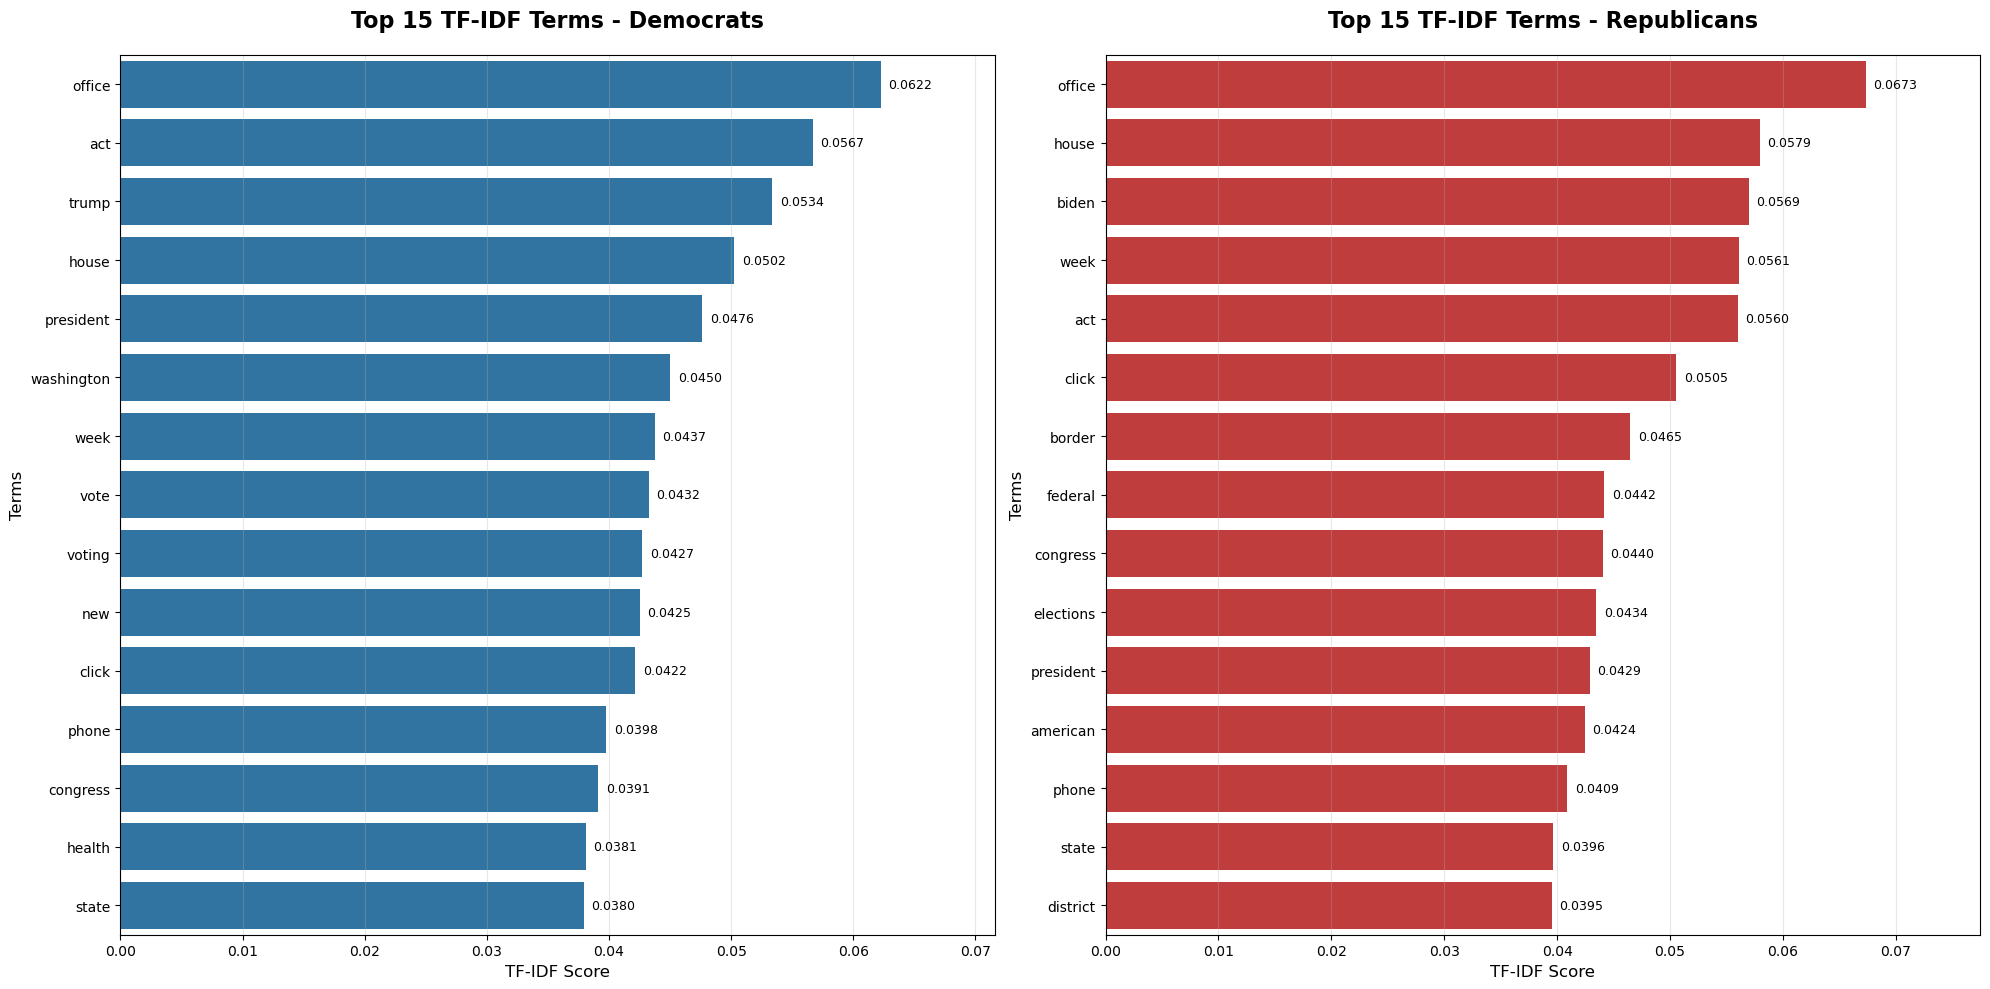

In [484]:
# Create separate bar plots for Democrat and Republican top 15 TF-IDF terms

# Define colors - blue for Democrats, red for Republicans
democrat_color = '#1f77b4'  # Professional blue
republican_color = '#d62728'  # Professional red

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Democrat plot (left)
dem_top_15 = d_tfidf_df.head(15)
sns.barplot(data=dem_top_15, y='word', x='tfidf_score', orient='h', color=democrat_color, ax=ax1)
ax1.set_title('Top 15 TF-IDF Terms - Democrats', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('TF-IDF Score', fontsize=12)
ax1.set_ylabel('Terms', fontsize=12)

# Add value labels for Democrats
dem_max_score = dem_top_15['tfidf_score'].max()
for i, v in enumerate(dem_top_15['tfidf_score']):
    ax1.text(v + (dem_max_score * 0.01), i, f'{v:.4f}', va='center', fontsize=9, ha='left')
ax1.set_xlim(0, dem_max_score * 1.15)
ax1.grid(axis='x', alpha=0.3)

# Republican plot (right)
rep_top_15 = r_tfidf_df.head(15)
sns.barplot(data=rep_top_15, y='word', x='tfidf_score', orient='h', color=republican_color, ax=ax2)
ax2.set_title('Top 15 TF-IDF Terms - Republicans', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('TF-IDF Score', fontsize=12)
ax2.set_ylabel('Terms', fontsize=12)

# Add value labels for Republicans
rep_max_score = rep_top_15['tfidf_score'].max()
for i, v in enumerate(rep_top_15['tfidf_score']):
    ax2.text(v + (rep_max_score * 0.01), i, f'{v:.4f}', va='center', fontsize=9, ha='left')
ax2.set_xlim(0, rep_max_score * 1.15)
ax2.grid(axis='x', alpha=0.3)

# Improve overall layout
plt.tight_layout()
plt.show()


## TF-IDF Implementation Approach

Initially, I attempted to implement TF-IDF analysis using the manual approach from the sample notebook `7_countingwords.ipynb`, building custom functions to calculate term frequency and inverse document frequency from scratch. However, this approach proved to be computationally inefficient when applied to our large political dataset containing thousands of documents. The manual implementation required nested loops to process each word in each document, resulting in extremely slow processing times that would have taken hours to complete. Recognizing the performance limitations of the manual approach, I transitioned to using scikit-learn's `TfidfVectorizer`, which leverages optimized algorithms and sparse matrix representations to handle large-scale text processing efficiently. This change not only dramatically improved processing speed but also provided built-in preprocessing capabilities like stopword removal and tokenization, making the analysis both faster and more robust for our political communication dataset.
